In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils

In [36]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        
        self.dis = nn.Sequential(
                      nn.Linear(784,512),
                      nn.LeakyReLU(0.2),
                      nn.Linear(512,256),
                      nn.LeakyReLU(0.2),
                      nn.Linear(256,1),
                      nn.Sigmoid()
                      )

    def forward(self,x):
        x = self.dis(x)
        return x

In [37]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        
        self.gen = nn.Sequential(
                      nn.Linear(128,256),
                      nn.LeakyReLU(0.2),
                      nn.Linear(256,512),
                      nn.LeakyReLU(0.2),
                      nn.Linear(512,784),
                      nn.Tanh()
                      )

    def forward(self,x):
        x = self.gen(x)
        return x

In [38]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root = './', train = True, download = True,transform = transform)
testset = torchvision.datasets.MNIST(root = './', train = False, download = True,transform = transform)

In [39]:
def one_hot(size):
    # tensor containing ones
    data = Variable(torch.ones(size, 1))
    return data

In [40]:
def zero_cold(size):
    # tensor containing zeroes
    data = Variable(torch.zeros(size, 1))
    return data

In [41]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size = 100, shuffle = True)
test_loader = torch.utils.data.DataLoader(testset, batch_size = 100, shuffle = False)

In [42]:
# init generator
generator = Generator()
# init discriminator
discriminator = Discriminator()
# adam optimizer for discriminator
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
# adam optimizer for generator
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
# init loss function
criterion = nn.BCELoss()

In [43]:
def train_generator(optimizer, data):
    # gradient is set to 0
    optimizer.zero_grad()
    # passing through the network
    net_out = discriminator(data)
    # calculaing BCE loss
    loss = criterion(net_out, one_hot(net_out.size(0)))
    # propogating loss at current step
    loss.backward()
    # updating parameters (in steps) after gradient descent
    optimizer.step()
    return loss

In [44]:
def train_discriminator(optimizer, real_data, fake_data):
    # gradient is set to 0
    optimizer.zero_grad()
    # Train/passing through the network on Real Data
    net_out_real = discriminator(real_data)
    # Calculaing BCE loss for real data
    loss_real = criterion(net_out_real, one_hot(real_data.size(0)))
    # propogating loss at current step
    loss_real.backward()

    # passing through the network on Fake Data
    net_out_fake = discriminator(fake_data)
    # calculaing BCE loss for fake data
    loss_fake = criterion(net_out_fake, zero_cold(fake_data.size(0)))
    # propogating loss at current step
    loss_fake.backward()
    
    # updating parameters (in steps) after gradient descent
    optimizer.step()
    
    return loss_real + loss_fake

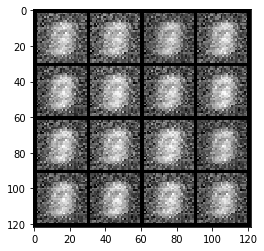

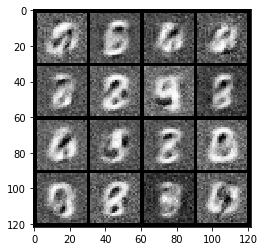

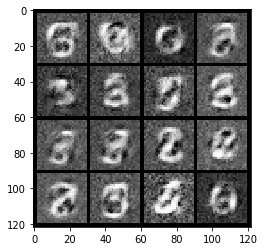

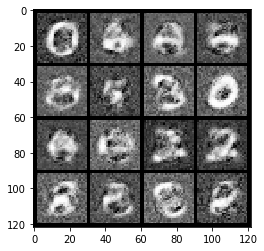

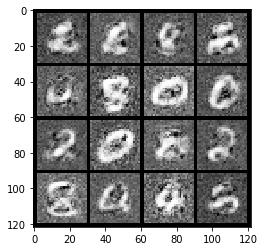

In [45]:
generator_error = []
discriminator_error = []
epochs = 50
for epoch in range(0,epochs):
    total_gen_error = 0
    total_disc_error = 0
    for batchId, (data,_)  in enumerate(train_loader,0):
        data = Variable(data.view(data.size(0), 784))
        noise = Variable(torch.randn(data.size(0), 128))

        # Generate fake data
        fake_data = generator(Variable(torch.randn(data.size(0), 128))).detach()

        # Train Discriminator
        disc_error = train_discriminator(d_optimizer, data, fake_data)
        
        # Generate fake data
        fake_data = generator(Variable(torch.randn(data.size(0), 128)))
        
        # Train Generator
        gen_error = train_generator(g_optimizer, fake_data)
        
        total_gen_error += gen_error
        total_disc_error += disc_error
#     print('Epoch: {} gen loss: {:.4f}, disc error: {:.4f}'.format(epoch, gen_error, disc_error))
    generator_error.append(total_gen_error.item()/batchId)
    discriminator_error.append(total_disc_error.item()/batchId)
    if (epoch) % 10 == 0:
        num_of_images = 16
        images = generator(Variable(torch.randn(num_of_images, 128)))
        images = images.view(images.size(0), 1, 28, 28)
        
        horizontal_grid = vutils.make_grid(images, normalize=True, scale_each=True,nrow=4)
        fig = plt.figure(figsize=(4, 4))
        plt.imshow(np.moveaxis(horizontal_grid.detach().numpy(), 0, -1))

Text(0, 0.5, 'Error')

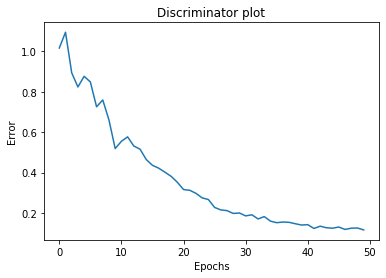

In [46]:
plt.plot(discriminator_error,label="Discriminator")
plt.title("Discriminator plot")
plt.xlabel("Epochs")
plt.ylabel("Error")
# plt.savefig(fname='gan_disc.png',format='png')

Text(0, 0.5, 'Error')

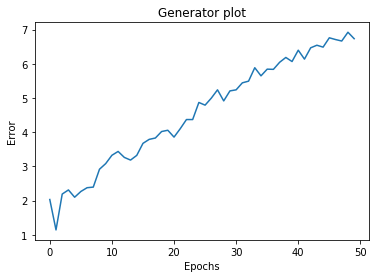

In [47]:
plt.plot(generator_error,label="Generator")
plt.title("Generator plot")
plt.xlabel("Epochs")
plt.ylabel("Error")
# plt.savefig(fname='gan_gen.png',format='png')

In [34]:
# torch.save(generator, "hw5_gan_gen.pth")
# torch.save(discriminator, "hw5_gan_dis.pth")